In [43]:
import numpy as np
import math
import sympy as sym
from sympy.functions.elementary.trigonometric import atan2
from scipy.integrate import ode
from sympy.utilities.lambdify import lambdify
import Kep_2_Cart
import Cart_2_Kep
import filter_functions
from IPython.core.debugger import Tracer
import warnings
import pickle
import matplotlib.pyplot as plt
warnings.filterwarnings('ignore')

#MSIS: https://github.com/DeepHorizons/Python-NRLMSISE-00
#import time
from nrlmsise_00_header import *
from nrlmsise_00 import *
#SUBROUTINE GTD7D -- d[5] is the "effective total mass density
#for drag" and is the sum of the mass densities of all species
#in this model, INCLUDING anomalous oxygen.

%matplotlib inline
plt.rcParams['figure.figsize'] = (14.0, 6.0)
plt.rcParams['xtick.labelsize'] = 14
plt.rcParams['ytick.labelsize'] = 14
np.set_printoptions(precision=15)
sym.init_printing()
from IPython.display import display


Notes:
- may want to change the mass and area of the space object to be more representative of a debris object, rather than a satellite


In [44]:

#define constants
r_earth_const = 6378136.3 #meters
omega_const = 7.2921158553e-5
J_2_const = .00108262617385222
J_3_const = -.00000253241051856772
mu_earth = 3.986004415e14 #m^3/s^2


#Drag:
A_const = 0.9551567 #meters^2; cross-sectional area of satellite
m_const = 10 #kg; mass of satellite
C_D_est = 2.0
theta_dot_const = 7.2921158553e-5 #rad/sec



In [45]:
#Define Problem Parameters

time_span = 86400
time_step = 120 #10


# meas_type = 1: range and range rate
# meas_type = 2: azimuth and elevation
meas_type = 3


#Measurement Type 1 (Range & Range Rate) Noise:
if meas_type == 1:
    meas1_stan_dev = .1 #meters
    meas2_stan_dev = .01 #meters/sec
#Measurement Type 2 (Az & El) Noise: 
if meas_type == 2:
    arcsec_per_rad = 206264.806247 #arcsec/rad
    noise_rad = (1/arcsec_per_rad)  * 5 #5 arcsec noise (suggested by Moriba for a telescope)
    meas1_stan_dev = noise_rad #radians
    meas2_stan_dev = noise_rad #radians
if meas_type == 3:
    arcsec_per_rad = 206264.806247 #arcsec/rad
    noise_rad = (1/arcsec_per_rad)  * 5 #5 arcsec noise (suggested by Moriba for a telescope)
    meas1_stan_dev = noise_rad #radians, az
    meas2_stan_dev = noise_rad #radians, el
    meas3_stan_dev = .1 #meters, range


#Date of Simulation Details:
#June 24th, 2017 at 6am (this is the date & time at the beginning of the simulation/orbit)
year = 2017
month = 6
day_of_month_init = 24
day_of_year_init = 175
hour_init_local = 6
boulder_UT_offset = 6 #Boulder time + 6 hours = UT time
hour_init_UT = hour_init_local + boulder_UT_offset


# define position and velocity vectors (meters & meters/sec)
#satellite
a = r_earth_const + 400*1e3 # meters
e = 0#.05
i = math.radians(40)#40
cap_omega = math.radians(90)
w = 0
nu = 0
(r_eci, v_eci) = Kep_2_Cart.COE2RV(a, e, i, cap_omega, w, nu, mu_earth)
print('Initial Position (ECI):', np.array(r_eci)/1e3, 'km')
print('Initial Velocity (ECI):', np.array(v_eci)/1e3, 'km')
print('Initial Orbit Altitude:', (np.linalg.norm(r_eci)- r_earth_const)/1e3, 'km')

period = 2*math.pi*math.sqrt(a**3/mu_earth)
print('Period of Orbit:', period/(60), 'minutes')


#Canbera Station (DSS 34) Australia
lat_dss34 = math.radians(-35.398333)
lon_dss34 = math.radians(148.981944)
alt_dss34 = 691.75 #m

r_ecef_dss34 = filter_functions.topo2ecef(lat_dss34, lon_dss34, alt_dss34, r_earth_const)
#print(r_ecef_dss34)

#Madrid Station (DSS 65) -- correct position of Madrid Station
lat_dss65 = math.radians(40.427222)
lon_dss65 = math.radians(355.749444)
alt_dss65 = 834.539 #m

r_ecef_dss65 = filter_functions.topo2ecef(lat_dss65, lon_dss65, alt_dss65, r_earth_const)
#print(r_ecef_dss65)

#Goldstone Station (DSS 13) California
lat_dss13 = math.radians(35.247164)
lon_dss13 = math.radians(243.205)
alt_dss13 = 0 #1071.14904 #m

r_ecef_dss13 = filter_functions.topo2ecef(lat_dss13, lon_dss13, alt_dss13, r_earth_const)
#print(r_ecef_dss13)


#Diego Garcia, British Indian Ocean Territory 7.41173°S 72.45222°E., Space Fence (Dedicated Sensor
lat_diego = math.radians(-7.41173)
lon_diego = math.radians(72.45222)
alt_diego = 0 #m, "sea level"

r_ecef_diego = filter_functions.topo2ecef(lat_diego, lon_diego, alt_diego, r_earth_const)




#ADD station on MAUI**********

Initial Position (ECI): [  4.150411461989742e-13   6.778136300000000e+03   0.000000000000000e+00] km
Initial Velocity (ECI): [ -5.874456678131549e+00   3.597067283801798e-16   4.929254431987093e+00] km
Initial Orbit Altitude: 400.0 km
Period of Orbit: 92.560390217187 minutes


In [46]:
#Propogate trajectory
def orbitpropogator_noSTM(t, X_vector, density):
    state = X_vector[0:3] 
    state_v = X_vector[3:6]
    
    x = state[0]
    y = state[1]
    z = state[2]

    #find X acceleration via the F(X) lambdified equation
    x_acc = x_sol_fcn(*state, *state_v, density)
    y_acc = y_sol_fcn(*state, *state_v, density)
    z_acc = z_sol_fcn(*state, *state_v, density)
    X_acc = np.array([x_acc, y_acc, z_acc])

    dx = np.array([state_v, X_acc])
    dx = dx.flatten()
    return dx



def calc_MSIS_density(t, X_vector):
    
    state = X_vector[0:3] 

    (latitude, longitude, altitude, day_of_month, hour) = \
                            filter_functions.calc_lat_lon_from_t_R(t, state, \
                                    day_of_month_init, hour_init_UT, month, year, omega_const, r_earth_const)
    
    day_of_year = math.floor(t/86400) + day_of_year_init
    t = t - math.floor(t/86400) * 86400
    
    if longitude < 0:
            longitude = longitude + 2*math.pi
    lst = filter_functions.calc_LST(hour, longitude) #lst in units of hours
    
    
    lon = 0 #dependent only on lst


    Output = nrlmsise_output()
    Input = nrlmsise_input()
    flags = nrlmsise_flags()
    aph = ap_array()

    for i in range(7):
        aph.a[i]=100
    flags.switches[0] = 1
    for i in range(1, 24):
        flags.switches[i]=1

    Input.doy = day_of_year
    Input.year = 0 #/* without effect */
    Input.sec = t
    Input.alt = altitude/1e3 #convert to km
    Input.g_lat = math.degrees(latitude)
    Input.g_long = math.degrees(lon)
    Input.lst = lst
    Input.f107A = 80 #I believe this is a "nominal" value
    Input.f107 = 80
    Input.ap = 4 

    gtd7d(Input, flags, Output)

    density = Output.d[5] #total mass density (grams/m^3, m^3 b/c switches[0] = 1)
    
    lst_rad = (lst/24) * np.radians(360) #radians

    return density, latitude, lst_rad




In [47]:
# **Setup Dynamical Model/Equations (Position & Velocity Forecast Model)

#Force equations: two body, J_2, & J_3
x, y, z, J_2, J_3, r_earth, mu, r,  x_dot, y_dot, z_dot, density = \
    sym.symbols('x y z J_2 J_3 r_earth mu r,  x_dot, y_dot, z_dot, density')
    
U_string = 'mu/r * ( 1 - J_2*(r_earth/r)**2 * (3/2 * (z/r)**2 - 1/2) )'
            #( 1 - J_2*(r_earth/r)**2 * (3/2 * (z/r)**2 - 1/2) ' #J_2 portion 
            #'- J_3 * (r_earth/r)**3 * ( 5/2 * (z/r)**3 - 3/2*(z/r) ) )') #J_3 portion 
U = sym.sympify(U_string)
U = U.subs(r, sym.sqrt(x**2+y**2+z**2))

U_diffeq_x = U.diff(x)
U_diffeq_y = U.diff(y)
U_diffeq_z = U.diff(z)


x_acc = U_diffeq_x.subs([(r_earth, r_earth_const), (mu, mu_earth), \
                              (J_2, J_2_const)])
y_acc = U_diffeq_y.subs([(r_earth, r_earth_const), (mu, mu_earth), \
                              (J_2, J_2_const)])
z_acc = U_diffeq_z.subs([(r_earth, r_earth_const), (mu, mu_earth), \
                              (J_2, J_2_const)])



#Add drag to J_2 force equations
C_D, A, m, density, theta_dot, val, val_dot = \
    sym.symbols('C_D A m density theta_dot val, val_dot')

drag_str = ('-(1/2)*C_D*(A/m)*density*'
                'sqrt((x_dot+theta_dot*y)**2 + (y_dot-theta_dot*x)**2 +'
                'z_dot**2)*(val_dot+theta_dot*val)')
drag_symp = sym.sympify(drag_str)

drag_symp = drag_symp.subs([(A, A_const), (m, m_const), (C_D, C_D_est),\
                        (theta_dot, theta_dot_const)])


x_drag_symp = drag_symp.subs([(r, sym.sqrt(x**2+y**2+z**2)), (val, y), (val_dot, x_dot)])
x_acc = x_acc + x_drag_symp

y_drag_symp = drag_symp.subs([(r, sym.sqrt(x**2+y**2+z**2)), (val, x), (val_dot, y_dot)])
y_acc = y_acc + y_drag_symp

z_drag_symp = drag_symp.subs([(r, sym.sqrt(x**2+y**2+z**2)), (val, z), (val_dot, z_dot)])
z_acc = z_acc + z_drag_symp


#print(z_acc)
    
x_sol_fcn = lambdify((x, y, z, x_dot, y_dot, z_dot, density), x_acc)
y_sol_fcn = lambdify((x, y, z, x_dot, y_dot, z_dot, density), y_acc)
z_sol_fcn = lambdify((x, y, z, x_dot, y_dot, z_dot, density), z_acc)




In [48]:

#initializations
t_init =  0
t_final = time_span #seconds
t_step = time_step
time_array = np.arange(t_init, t_final+t_step, t_step)

#set the initial values for the propogator:
#reference trajectory
y0 = np.array([r_eci, v_eci])
y0 = y0.flatten()

density_array = np.zeros((len(time_array)))
lat_lst_array = np.zeros((len(time_array), 2))

integrator = ode(orbitpropogator_noSTM)
integrator.set_integrator('dopri5', nsteps=1e6, rtol=3e-14, atol=1e-16)
integrator.set_initial_value(y0, t_init)

result = []
result.append(np.insert(y0, 0, t_init))
X_vector = y0
t = t_init
counter = 0

while integrator.successful() and integrator.t < t_final:
    density, lat, lst = calc_MSIS_density(t, X_vector)
    integrator.set_f_params(density)
    integrator.integrate(integrator.t + t_step)
    X_vector = integrator.y
    t = integrator.t
    density_array[counter] = density
    lat_lst_array[counter] = [lat, lst]
    result.append(np.insert(X_vector, 0, t))
    counter = counter + 1
    

result = np.array(result)

integrator_times = result[:, 0]
X = result[:, [1, 2, 3]]
V = result[:, [4, 5, 6]]
truth_pos_vel = result[:, [1, 2, 3, 4, 5, 6]]
pos_init = X[0]
vel_init = V[0]

#print(day_of_year, t, alt/1000, math.degrees(lat), math.degrees(lon), lst)

In [49]:
0.00085738173421523673, -93.325445384706796


In [50]:
#generate measurements


if (meas_type == 1) or (meas_type == 3):

    
    x_s, y_s, z_s, x_sf, y_sf, z_sf, theta, theta_dot, t, x_dot, y_dot, z_dot = \
        sym.symbols('x_s, y_s, z_s, x_sf, y_sf, z_sf, theta, theta_dot, t, x_dot, y_dot, z_dot')

    #define symbolic rho equation
    rho = ('sqrt((x - x_s)**2 + (y - y_s)**2 + (z - z_s)**2)')
    rho = sym.sympify(rho)
    #sub rotation equation of ecef for eci
    rho = rho.subs(x_s, x_sf*sym.cos(omega_const*t) - y_sf*sym.sin(omega_const*t))
    rho = rho.subs(y_s, x_sf*sym.sin(omega_const*t) + y_sf*sym.cos(omega_const*t))
    rho = rho.subs(z_s, z_sf)

    #define symbolic rho dot equation
    rho_dot = ('(x*x_dot + y*y_dot + z*z_dot - (x_dot*x_s+y_dot*y_s)*cos(theta) + \
               theta_dot*(x*x_s + y*y_s)*sin(theta) + (x_dot*y_s - y_dot*x_s)*sin(theta) +\
               theta_dot*(x*y_s - y*x_s)*cos(theta) - z_dot*z_s)/ rho')
    rho_dot = sym.sympify(rho_dot)
    #execute substitutions for rho_dot
    rho_dot = rho_dot.subs(x_s, x_sf) 
    rho_dot = rho_dot.subs(y_s, y_sf) 
    rho_dot = rho_dot.subs(z_s, z_sf) 
    rho_dot = rho_dot.subs('rho', rho)
    rho_dot = rho_dot.subs(theta, omega_const*t)    
    rho_dot = rho_dot.subs(theta_dot, omega_const)

    rho_fcn = lambdify(((x, y, z, x_sf, y_sf, z_sf, t)), rho)
    rho_dot_fcn = lambdify(((x, y, z, x_dot, y_dot, z_dot, x_sf, y_sf, z_sf, t)), rho_dot)


if (meas_type == 2) or (meas_type == 3):
    
    #x_sf, etc. is the sensor pos in ecef
    #x, y, z is the satellite eci
    x_s, y_s, z_s, x_sf, y_sf, z_sf, theta, x, y, z, t = \
        sym.symbols('x_s, y_s, z_s, x_sf, y_sf, z_sf, theta, x, y, z, t')
    x_L, y_L, z_L, X_L_norm, x_range, y_range, z_range, lon, lat, \
        x_sat_ecef, y_sat_ecef, z_sat_ecef, sen_ecef_norm, omega  = \
        sym.symbols('x_L, y_L, z_L, X_L_norm, x_range, y_range, z_range, lon, lat, \
        x_sat_ecef, y_sat_ecef, z_sat_ecef, sen_ecef_norm, omega')
        

    #define symbolic rho equation
    azimuth = ('atan2(x_L, y_L)') #step 4
    azimuth = sym.sympify(azimuth)
    
    elevation = ('asin(z_L/X_L_norm)') #step 4
    elevation = sym.sympify(elevation)
    elevation = elevation.subs(X_L_norm, sym.sqrt(x_L**2 + y_L**2 + z_L**2))
    
    #step 3
    azimuth = azimuth.subs([(x_L, -x_range*sym.sin(lon) + y_range*sym.cos(lon)), \
            (y_L, -x_range*sym.sin(lat)*sym.cos(lon) - y_range*sym.sin(lat)*sym.sin(lon) + z_range*sym.cos(lat))])
    elevation = elevation.subs([(x_L, -x_range*sym.sin(lon) + y_range*sym.cos(lon)), \
            (y_L, -x_range*sym.sin(lat)*sym.cos(lon) - y_range*sym.sin(lat)*sym.sin(lon) + z_range*sym.cos(lat)), \
            (z_L, x_range*sym.cos(lat)*sym.cos(lon) + y_range*sym.cos(lat)*sym.sin(lon) + z_range*sym.sin(lat))])
    
    #step 2
    azimuth = azimuth.subs([(x_range, x_sat_ecef - x_sf), (y_range, y_sat_ecef - y_sf), \
            (z_range, z_sat_ecef - z_sf), (lat, sym.asin(z_sf/sen_ecef_norm)), (lon, sym.atan2(y_sf, x_sf))])
    elevation = elevation.subs([(x_range, x_sat_ecef - x_sf), (y_range, y_sat_ecef - y_sf), \
            (z_range, z_sat_ecef - z_sf), (lat, sym.asin(z_sf/sen_ecef_norm)), (lon, sym.atan2(y_sf, x_sf))])
    
    #step 1
    azimuth = azimuth.subs([(x_sat_ecef, x*sym.cos(theta) + y*sym.sin(theta)), \
                        (y_sat_ecef, -x*sym.sin(theta) + y*sym.cos(theta)), (z_sat_ecef, z), \
                        (sen_ecef_norm, sym.sqrt(x_sf**2 + y_sf**2 + z_sf**2))])
    elevation = elevation.subs([(x_sat_ecef, x*sym.cos(theta) + y*sym.sin(theta)), \
                        (y_sat_ecef, -x*sym.sin(theta) + y*sym.cos(theta)), (z_sat_ecef, z), \
                        (sen_ecef_norm, sym.sqrt(x_sf**2 + y_sf**2 + z_sf**2))])
    
    azimuth = azimuth.subs([(theta, omega*t), (omega, omega_const)])
    elevation = elevation.subs([(theta, omega*t), (omega, omega_const)])
    
    azimuth_fcn = lambdify(((x, y, z, x_sf, y_sf, z_sf, t)), azimuth)
    elevation_fcn = lambdify(((x, y, z, x_sf, y_sf, z_sf, t)), elevation)
    
    


In [51]:
#calculate measurements for each station
#determine if visible and add to measurement array
measurement_array = []
object_eci_pos_vel = []
lat_lst_array_final = []
density_array_final = []

meas3 = 0

for s in range(len(integrator_times)):

    
    object_eci = np.array([X[s]])
    time = integrator_times[s] #time since epoch in seconds
    
    
    elevation1 = filter_functions.calculate_elevation(r_ecef_dss34, object_eci, time, omega_const, r_earth_const)
    elevation2 = filter_functions.calculate_elevation(r_ecef_dss65, object_eci, time, omega_const, r_earth_const)
    elevation3 = filter_functions.calculate_elevation(r_ecef_diego, object_eci, time, omega_const, r_earth_const)
    

    
    if((elevation1 < 90) & (elevation1 > 10)):
    #if((s > 10) & (s < 20)):
        #print(integrator_times[s], elevation)
        #print('station 34')

        #calculate range and range rate
        if meas_type == 1:
            meas1 = rho_fcn(*X[s], *r_ecef_dss34, integrator_times[s])
            meas2 = rho_dot_fcn(*X[s], *V[s], *r_ecef_dss34, integrator_times[s])
        #calculate azimuth & elevation
        elif (meas_type == 2) or (meas_type == 3):
            meas1 = azimuth_fcn(*X[s], *r_ecef_dss34, integrator_times[s])
            meas2 = elevation_fcn(*X[s], *r_ecef_dss34, integrator_times[s])
            if meas1 < 0:
                meas1 = meas1 + 2*math.pi
        if meas_type == 3:
            meas3 = rho_fcn(*X[s], *r_ecef_dss34, integrator_times[s])

        measurement_array.append([integrator_times[s], 1, meas1, meas2, meas3])
        object_eci_pos_vel.append(*[truth_pos_vel[s]])
        lat_lst_array_final.append(*[lat_lst_array[s]])
        density_array_final.append(density_array[s])

    
    elif((elevation2 < 90) & (elevation2 > 10)):
    #if(s < 10):
        #print('station 65')
        #print(*X[s], *r_ecef_dss65, integrator_times[s])

        #calculate range and range rate
        if meas_type == 1:
            meas1 = rho_fcn(*X[s], *r_ecef_dss65, integrator_times[s])
            meas2 = rho_dot_fcn(*X[s], *V[s], *r_ecef_dss65, integrator_times[s])
        #calculate azimuth & elevation
        elif (meas_type == 2) or (meas_type == 3):
            meas1 = azimuth_fcn(*X[s], *r_ecef_dss65, integrator_times[s])
            meas2 = elevation_fcn(*X[s], *r_ecef_dss65, integrator_times[s])
            if meas1 < 0:
                meas1 = meas1 + 2*math.pi
        if meas_type == 3:
            meas3 = rho_fcn(*X[s], *r_ecef_dss65, integrator_times[s])


        #add to array of observations
        measurement_array.append([integrator_times[s], 2, meas1, meas2, meas3])
        object_eci_pos_vel.append(*[truth_pos_vel[s]])
        lat_lst_array_final.append(*[lat_lst_array[s]])
        density_array_final.append(density_array[s])

      
    else:
        #print('amosn station')
        #print(*X[s], *r_ecef_amos, integrator_times[s])

        #calculate range and range rate
        if meas_type == 1:
            meas1 = rho_fcn(*X[s], *r_ecef_diego, integrator_times[s])
            meas2 = rho_dot_fcn(*X[s], *V[s], *r_ecef_diego, integrator_times[s])
        #calculate azimuth & elevation
        elif (meas_type == 2) or (meas_type == 3):
            meas1 = azimuth_fcn(*X[s], *r_ecef_diego, integrator_times[s])
            meas2 = elevation_fcn(*X[s], *r_ecef_diego, integrator_times[s])
            if meas1 < 0:
                meas1 = meas1 + 2*math.pi
        if meas_type == 3:
            meas3 = rho_fcn(*X[s], *r_ecef_diego, integrator_times[s])


        #add to array of observations
        measurement_array.append([integrator_times[s], 4, meas1, meas2, meas3])
        object_eci_pos_vel.append(*[truth_pos_vel[s]])
        lat_lst_array_final.append(*[lat_lst_array[s]])
        density_array_final.append(density_array[s])



measurement_array = np.array(measurement_array)
object_eci_pos_vel = np.array(object_eci_pos_vel)
lat_lst_array_final = np.array(lat_lst_array_final)
density_array_final = np.array(density_array_final)



In [52]:
indices = np.where(measurement_array[:, 1] == 1)[0]
print(indices)
indices = np.where(measurement_array[:, 1] == 2)[0]
print(indices)
indices = np.where(measurement_array[:, 1] == 3)[0]
print(indices)
indices = np.where(measurement_array[:, 1] == 4)[0]
print(indices)

[305 306 307 353 354 355 356 402 403 404 451 452 453 499 500 501 502]
[284 285 286 332 333 334 381 382 383 429 430 431]
[]
[  0   1   2   3   4   5   6   7   8   9  10  11  12  13  14  15  16  17
  18  19  20  21  22  23  24  25  26  27  28  29  30  31  32  33  34  35
  36  37  38  39  40  41  42  43  44  45  46  47  48  49  50  51  52  53
  54  55  56  57  58  59  60  61  62  63  64  65  66  67  68  69  70  71
  72  73  74  75  76  77  78  79  80  81  82  83  84  85  86  87  88  89
  90  91  92  93  94  95  96  97  98  99 100 101 102 103 104 105 106 107
 108 109 110 111 112 113 114 115 116 117 118 119 120 121 122 123 124 125
 126 127 128 129 130 131 132 133 134 135 136 137 138 139 140 141 142 143
 144 145 146 147 148 149 150 151 152 153 154 155 156 157 158 159 160 161
 162 163 164 165 166 167 168 169 170 171 172 173 174 175 176 177 178 179
 180 181 182 183 184 185 186 187 188 189 190 191 192 193 194 195 196 197
 198 199 200 201 202 203 204 205 206 207 208 209 210 211 212 213 214 215
 

In [53]:
#add noise to measurements

print(np.shape(measurement_array))

#get initial noise values between -1 and 1
meas1_noise = np.random.randn(len(measurement_array))
meas2_noise = np.random.randn(len(measurement_array))

#meas1_stan_dev & meas2_stan_dev defined at the top of code w/ other tuning params

meas1_noise = meas1_noise * meas1_stan_dev
meas2_noise = meas2_noise * meas2_stan_dev

measurement_array[:, 2] = measurement_array[:, 2] + meas1_noise
measurement_array[:, 3] = measurement_array[:, 3] + meas2_noise

if meas_type == 3:
    meas3_noise = np.random.randn(len(measurement_array))
    meas3_noise = meas3_noise * meas3_stan_dev
    measurement_array[:, 4] = measurement_array[:, 4] + meas2_noise

(721, 5)


In [54]:
# write python dict to a file
#measurement_array, truth_pos_vel, J_3_array
mydict = {'measurement_array': measurement_array, 'truth_pos_vel': object_eci_pos_vel, 'true_density': density_array_final,\
                                                                     'lat_lst_array': lat_lst_array_final}
if meas_type == 1:
    output = open('Data Files/meas_range_rangeRate.pkl', 'wb')
elif meas_type == 2:
    output = open('Data Files/meas_az_el.pkl', 'wb')
elif meas_type == 3:
    output = open('Data Files/meas_az_el_range_complexDensity.pkl', 'wb')
    
pickle.dump(mydict, output, protocol=2)
output.close()

## Analyze Measurements:

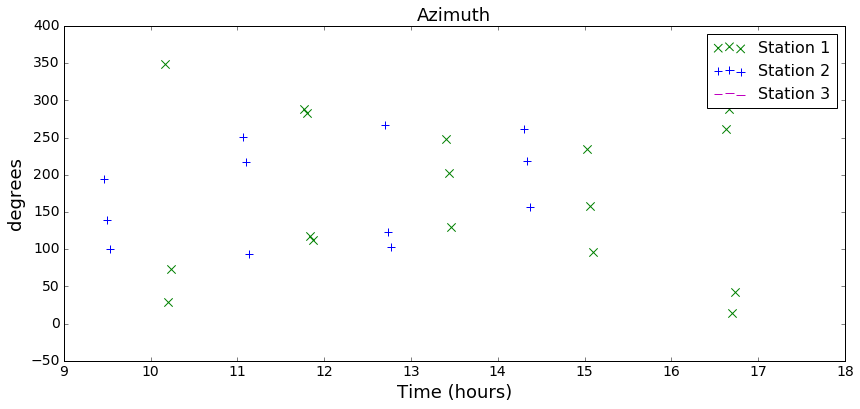

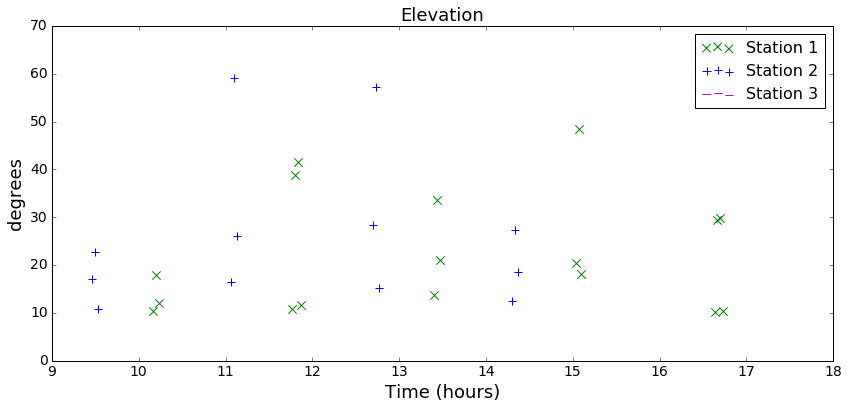

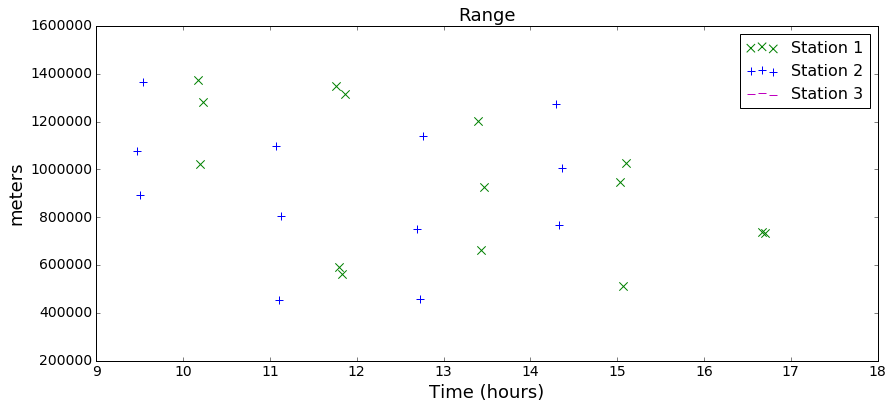

In [55]:
legend_names = ['Station 1', 'Station 2', 'Station 3']

if meas_type == 1:

    times = measurement_array[:, 0]/(60*60)
    
    indices_34 = np.where(measurement_array[:, 1] == 1)[0]
    indices_65 = np.where(measurement_array[:, 1] == 2)[0]
    indices_13 = np.where(measurement_array[:, 1] == 3)[0]


    fig = plt.figure()
    plt.scatter(times[indices_34], measurement_array[indices_34, 2], s=70, c='g', marker='x')
    plt.scatter(times[indices_65], measurement_array[indices_65, 2], s=70, c='b', marker='+')
    plt.scatter(times[indices_13], measurement_array[indices_13, 2], s=70, c='m', marker='_')
    plt.ylabel('meters', fontsize=18)
    plt.xlabel('Time (hours)', fontsize=18)
    plt.title('Range', fontsize=18)
    plt.legend(legend_names, fontsize=16)
    #plt.ylim([-y_range,y_range])
    #plt.xlim([0,time_hrs[-1]])
    plt.show()
    #fig.savefig('Images/range_meas_basic.png')


    fig = plt.figure()
    plt.scatter(times[indices_34], measurement_array[indices_34, 3], s=70, c='g', marker='x')
    plt.scatter(times[indices_65], measurement_array[indices_65, 3], s=70, c='b', marker='+')
    plt.scatter(times[indices_13], measurement_array[indices_13, 3], s=70, c='m', marker='_')
    plt.ylabel('meters/sec', fontsize=18)
    plt.xlabel('Time (hours)', fontsize=18)
    plt.title('Range Rate', fontsize=18)
    plt.legend(legend_names, fontsize=16)
    #plt.ylim([-y_range,y_range])
    #plt.xlim([0,time_hrs[-1]])
    plt.show()
    #fig.savefig('Images/range_rate_meas_basic.png')


elif (meas_type == 2) or (meas_type == 3):

    times = measurement_array[:, 0]/(60*60)
    
    indices_34 = np.where(measurement_array[:, 1] == 1)[0]
    indices_65 = np.where(measurement_array[:, 1] == 2)[0]
    indices_13 = np.where(measurement_array[:, 1] == 3)[0]
    

    fig = plt.figure()
    plt.scatter(times[indices_34], np.degrees(measurement_array[indices_34, 2]), s=70, c='g', marker='x')
    plt.scatter(times[indices_65], np.degrees(measurement_array[indices_65, 2]), s=70, c='b', marker='+')
    plt.scatter(times[indices_13], np.degrees(measurement_array[indices_13, 2]), s=70, c='m', marker='_')
    plt.ylabel('degrees', fontsize=18)
    plt.xlabel('Time (hours)', fontsize=18)
    plt.title('Azimuth', fontsize=18)
    plt.legend(legend_names, fontsize=16)
    #plt.ylim([-y_range,y_range])
    #plt.xlim([0,time_hrs[-1]])
    plt.show()
    #fig.savefig('Images/az_meas.png')


    fig = plt.figure()
    plt.scatter(times[indices_34], np.degrees(measurement_array[indices_34, 3]), s=70, c='g', marker='x')
    plt.scatter(times[indices_65], np.degrees(measurement_array[indices_65, 3]), s=70, c='b', marker='+')
    plt.scatter(times[indices_13], np.degrees(measurement_array[indices_13, 3]), s=70, c='m', marker='_')
    plt.ylabel('degrees', fontsize=18)
    plt.xlabel('Time (hours)', fontsize=18)
    plt.title('Elevation', fontsize=18)
    plt.legend(legend_names, fontsize=16)
    #plt.ylim([-y_range,y_range])
    #plt.xlim([0,time_hrs[-1]])
    plt.show()
    #fig.savefig('Images/el_meas_basic.png')

if meas_type == 3:
    
    times = measurement_array[:, 0]/(60*60)
    
    indices_34 = np.where(measurement_array[:, 1] == 1)[0]
    indices_65 = np.where(measurement_array[:, 1] == 2)[0]
    indices_13 = np.where(measurement_array[:, 1] == 3)[0]


    fig = plt.figure()
    plt.scatter(times[indices_34], measurement_array[indices_34, 4], s=70, c='g', marker='x')
    plt.scatter(times[indices_65], measurement_array[indices_65, 4], s=70, c='b', marker='+')
    plt.scatter(times[indices_13], measurement_array[indices_13, 4], s=70, c='m', marker='_')
    plt.ylabel('meters', fontsize=18)
    plt.xlabel('Time (hours)', fontsize=18)
    plt.title('Range', fontsize=18)
    plt.legend(legend_names, fontsize=16)
    #plt.ylim([-y_range,y_range])
    #plt.xlim([0,time_hrs[-1]])
    plt.show()
    #fig.savefig('Images/range_meas_basic.png')

In [56]:


density_array = np.zeros(len(object_eci_pos_vel))
times = measurement_array[:, 0]/(60*60*24)


for index in range(len(object_eci_pos_vel)): 
    
    
    t = measurement_array[index, 0]
    X_vector = object_eci_pos_vel[index, :]

    
    density = calc_MSIS_density(t, X_vector)
    density_array[index] = density
    
    
    

y_range_min = .5e-12
y_range_max = .1e-11

fig = plt.figure()
plt.scatter(times, density_array, s=70, c='m', marker='x')
plt.ylabel('Atmospheric Density (kg/m^3)', fontsize=18)
plt.xlabel('time (days)', fontsize=18)
plt.title('MSIS Atmosphric Density at Measurement Times', fontsize=18)
#legend_names = ['Simple', 'Complex']
#plt.legend(legend_names, fontsize=16)
plt.ylim([y_range_min,y_range_max])
plt.show()
fig.savefig('density_dif_sampling.png')

ValueError: setting an array element with a sequence.

In [ ]:
# write python dict to a file
#times, xyz pos, xyz vel
mydict = {'truth_xyz': result}
if meas_type == 1:
    output = open('Data Files/truth_range_rangeRate.pkl', 'wb')
elif meas_type == 2:
    output = open('Data Files/truth_az_el.pkl', 'wb')
    
pickle.dump(mydict, output)
output.close()

In [ ]:
np.shape(lat_lst_array_final)


